# This notebook trains XGboost model on the second cluster buildings. big-label-1 contains the data of all the buildings in the second cluster

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import time
import resource

In [11]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Function to optimize data types
def optimize_data_types(df):
    # Optimize numeric columns
    for col in df.select_dtypes(include=['int']).columns:
        df[col] = df[col].astype('int32')
    
    for col in df.select_dtypes(include=['float']).columns:
        df[col] = df[col].astype('float32')

    # Optimize object columns
    for col in df.select_dtypes(include=['object']).columns:
        num_unique_values = len(df[col].unique())
        num_total_values = len(df[col])
        if num_unique_values / num_total_values < 0.5:
            df[col] = df[col].astype('category')
    
    return df

# Load the data and remove the first and last columns
df = pd.read_csv('/kaggle/input/big-label-1/df_labeled1.csv')
df = df.iloc[:, 1:-1]

# Optimize data types
df = optimize_data_types(df)

# Verify DataFrame shape
print("DataFrame shape:", df.shape)
print("DataFrame head:", df.head())

# Define the window size for lagged inputs
window_size = 40  # Replace N with your desired window size

# Function to process each chunk
def process_chunk(chunk, window_size):
    data = []
    for i, row in chunk.iterrows():
        values = row.values
        for t in range(window_size, len(values)):
            lagged_inputs = values[t-window_size:t]
            target_value = values[t]

            timestamp = pd.Timestamp('2009-07-14 00:00:00') + pd.Timedelta(hours=t)
            year = timestamp.year
            month = timestamp.month
            day = timestamp.day
            hour = timestamp.hour

            data.append(list(lagged_inputs) + [year, month, day, hour, target_value])
    return data

# Create an empty DataFrame to store results
columns = [f'lag_{i}' for i in range(1, window_size+1)] + ['year', 'month', 'day', 'hour', 'target']
df_transformed = pd.DataFrame(columns=columns)

# Process the data in chunks
chunk_size = 100  # Adjust based on available memory
for start_row in range(0, df.shape[0], chunk_size):
    chunk = df.iloc[start_row:start_row + chunk_size]
    data = process_chunk(chunk, window_size)
    df_chunk_transformed = pd.DataFrame(data, columns=columns)
    df_transformed = pd.concat([df_transformed, df_chunk_transformed], ignore_index=True)


ordinal_encoder = OrdinalEncoder()
df_transformed[['month', 'day', 'hour']] = ordinal_encoder.fit_transform(df_transformed[['month', 'day', 'hour']])


print("Transformation complete. The new dataset is saved as 'transformed_dataset.csv'.")



DataFrame shape: (596, 12865)
DataFrame head:    2009-07-14 00:00:00  2009-07-14 01:00:00  2009-07-14 02:00:00  \
0                1.310                2.360                1.693   
1                0.614                1.142                1.139   
2                1.757                3.253                3.151   
3                0.126                0.098                0.108   
4                0.387                0.663                0.646   

   2009-07-14 03:00:00  2009-07-14 04:00:00  2009-07-14 05:00:00  \
0                1.738                0.833                0.789   
1                0.836                0.805                0.826   
2                2.689                1.250                1.163   
3                0.077                0.072                0.096   
4                0.660                0.625                0.682   

   2009-07-14 06:00:00  2009-07-14 07:00:00  2009-07-14 08:00:00  \
0                0.709                0.756                1.397   


/tmp/ipykernel_33/2433833717.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_transformed = pd.concat([df_transformed, df_chunk_transformed], ignore_index=True)


Transformation complete. The new dataset is saved as 'transformed_dataset.csv'.


In [12]:
######CORRECT IT
import pandas as pd
import gc
# Convert the date columns to datetime
df_transformed['year1'] = df_transformed['year']
df_transformed['month1'] = df_transformed['month']
df_transformed['day1'] = df_transformed['day']
df_transformed['hour1'] = df_transformed['hour']
df_transformed["target1"] = df_transformed["target"]

# Define the date ranges for training and testing
train_start_date = '2009-07-14'
train_end_date = '2010-12-15'
test_start_date = '2010-12-15'
test_end_date = '2011-01-01'

# Convert the date columns to datetime
df_transformed['year'] = df_transformed['year'].astype(int)
df_transformed['month'] = df_transformed['month'].astype(int)+1
df_transformed['day'] = df_transformed['day'].astype(int)+1
df_transformed['hour'] = df_transformed['hour'].astype(int)+1

# Create a datetime column
df_transformed['date_time'] = pd.to_datetime(df_transformed[['year', 'month', 'day', 'hour']])
df_sample = df_transformed.loc[:12825]

# Set the datetime column as the index
df_transformed.set_index('date_time', inplace=True)
df_sample.set_index('date_time', inplace=True)

# Drop the irrelevant columns
df_transformed.drop(columns=['year', 'month', 'day', 'hour','target'], inplace=True)
df_sample.drop(columns=['year', 'month', 'day', 'hour','target'], inplace=True)

#Separate the input features (lagged values) and the target variable
features = df_transformed.columns[:-1]  # All columns except the last one
target = df_transformed.columns[-1]     # The last column

df_transformed = df_transformed.sort_index()
df_sample = df_sample.sort_index()

# Split the data into training and testing sets
X_train = df_transformed.loc[train_start_date:train_end_date,features]
y_train = df_transformed.loc[train_start_date:train_end_date,target]

X_test = df_transformed.loc[test_start_date:test_end_date,features]
y_test = df_transformed.loc[test_start_date:test_end_date,target]


# Create sample data for the first building
X_sample = df_sample.loc[test_start_date:test_end_date,features]
y_sample = df_sample.loc[test_start_date:test_end_date,target]



del df_transformed, df
gc.collect()

/tmp/ipykernel_33/3636548432.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample.drop(columns=['year', 'month', 'day', 'hour','target'], inplace=True)


0

In [14]:
X_train["year1"]=X_train["year1"].astype(int)
X_test["year1"]=X_test["year1"].astype(int)
X_sample["year1"]=X_sample["year1"].astype(int)

In [24]:
def get_memory_usage():
    # Return current memory usage in MB
    return resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024

start_mem = get_memory_usage()
# Initialize the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500)
end_mem = get_memory_usage()
print(f"Memory used for model creation: {end_mem - start_mem} MB")


# Train the model
start_mem = get_memory_usage()
time1=time.time()
model.fit(X_train, y_train)
time2=time.time()
end_mem = get_memory_usage()
print(f"Memory used for model training: {end_mem - start_mem} MB")
print("training time is ",time2-time1)

Memory used for model creation: 0.0 MB
Memory used for model training: 1.79296875 MB
training time is  5.4675822257995605


In [17]:
def sMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

In [18]:
# Make predictions on the test data
y_train_pred = model.predict(X_train)

# Evaluate the model performance on the test data
train_mse = mean_squared_error(y_train, y_train_pred)
train_smape = sMAPE(y_train, y_train_pred)
print(f"Train MSE: {train_mse}")
print(f"Train sMAPE: {train_smape}")

Train MSE: 0.0018908445490524173
Train sMAPE: 2.570386684209204


In [25]:
# Make predictions on the test data
y_test_pred = model.predict(X_test)

# Evaluate the model performance on the test data
test_mse = mean_squared_error(y_test, y_test_pred)
test_smape = sMAPE(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")
print(f"Test sMAPE: {test_smape}")



Test MSE: 1.7357650995254517
Test sMAPE: 39.100512993044966
training time is  0.0076313018798828125


In [20]:
# Make predictions on the sample data
y_sample_pred = model.predict(X_sample)

# Evaluate the model performance on the sample data
sample_mse = mean_squared_error(y_sample, y_sample_pred)
sample_smape = sMAPE(y_sample, y_sample_pred)
print(f"Sample MSE: {sample_mse}")
print(f"Sample sMAPE: {sample_smape}")



Sample MSE: 1.7357650995254517
Sample sMAPE: 39.100512993044966


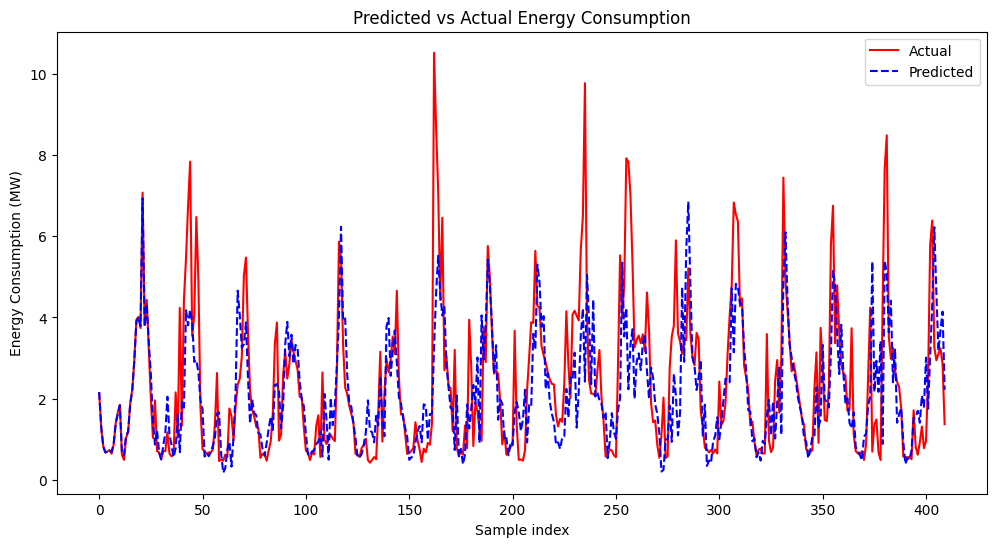

In [21]:
# Plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_sample)), y_sample, label='Actual', color='red')
plt.plot(range(len(y_sample_pred)), y_sample_pred, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Sample index')
plt.ylabel('Energy Consumption (MW)')
plt.title('Predicted vs Actual Energy Consumption')
plt.legend()
plt.show()